### https://unexpectedcoder.github.io/computer-sim-labs/lab-1-ca-forest.html

In [100]:
import matplotlib.pyplot as plt
import numpy as np
from time import sleep
from IPython.display import clear_output
from enum import Enum
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
from typing import Optional, Tuple, List


In [135]:
# "Seed" for the pseudorandom number generator
seed = 1097
# Dimensions of the cellular field
w, h = 200, 200
# Fraction of cells with trees
eta = 1/2
# Number of initially burning trees
f = 1
# Probability of a new tree growing
p_g = 0.02
# Probability of random ignition of a tree
p_f = 2e-5
# Model time (number of automaton updates)
sim_time = 500

In [11]:
rs = np.random.RandomState(seed=seed)

colors = ["#49423D", "orange", "green"]
cmap_forest = ListedColormap(colors)

In [43]:
Matrix = np.ndarray
Array = np.ndarray
Axes = plt.Axes
Figure = plt.Figure

In [13]:
class NeighborhoodType(Enum):
    CROSS = '+'
    NEUMAN = 'x'
    
class CellState(Enum):
    EMPTY = 0
    FIRING = 1
    TREE = 2
    
class CellColor(Enum):
    EMPTY = colors[0]
    FIRING = colors[1]
    TREE = colors[2]

In [14]:
def plot_grid(ca: Matrix, ax: Optional[Axes]=None, **kw) -> Tuple[Figure, Axes]:
    """
    Draws a colored grid from a matrix.
    
    ca - input matrix with numbers
    ax - existing plot axes (if None, creates new)
    **kw - optional parameters like title="My plot"
    
    Returns: figure and axes objects
    """
    if ax is None:
        fig, ax = plt.subplots()

    ax.matshow(ca, cmap=cmap_forest)
    title = kw.get("title", "")
    ax.set(
        xlabel="Length",
        ylabel="Width",
        title=title,
        aspect="equal"
    )

    return fig, ax

In [77]:
def create_ca(h: int, w: int) -> Matrix:
    """
    Creates empty matrix of size h x w.
    """
    return np.zeros((h, w))

def grow_trees(ca: Matrix, eta: float) -> Matrix:
    """
    Gets zeros like matrix.
    Changes matrix depending on density eta.
    Returns: result matrix.
    """
    random_matrix = np.random.random(ca.shape) + 1e-10
    return np.where(random_matrix <= eta, CellState.TREE.value, ca)

def firing_trees(ca: Matrix, f: int) -> Matrix:
    """
    Returns: matrix with random f amount of CellState.FIRING values.
    """
    h, w = ca.shape
    firing_xs = np.random.randint(low=0, high=w, size=f)
    firing_ys = np.random.randint(low=0, high=h, size=f)
    result = ca.copy()
    result[firing_ys, firing_xs] = CellState.FIRING.value
    return result

def init_state(ca: Matrix, eta: float, f: int) -> Matrix:
    """
    Returns: initialized matrix
    """
    trees = grow_trees(ca, eta)
    firing = firing_trees(trees, f)
    return firing

In [72]:
def get_cross_neighborhood(cell: Tuple[int, int],
                           ca_shape: Tuple[int, int]) -> Array:
    """
    Returns: indexes of surrounding cells in case of "+"-neighborhood.
    """
    
    directions = np.array([(-1, 0), (1, 0), (0, -1), (0, 1)], dtype=object)
    h, w = ca_shape
    cell_array = np.array([cell for _ in range(4)])
    neighbors = directions + cell_array
    r, c = directions.shape
    for row in range(r):
        if neighbors[row][0] < 0 or neighbors[row][1] < 0:
            neighbors[row][0] = None
            neighbors[row][1] = None
        elif neighbors[row][0] >= h:
            neighbors[row][0] = None
            neighbors[row][1] = None
        elif neighbors[row][1] >= w:
            neighbors[row][0] = None
            neighbors[row][1] = None
    return neighbors

In [74]:
def get_neuman_neighborhood(cell: Tuple[int, int],
                            ca_shape: Tuple[int, int]) -> Array:
    """
    Returns: indexes of surrounding cells in case of "x"-neighborhood.
    """
    directions = np.array([(-1, 0), (1, 0), (0, -1), (0, 1), 
                           (-1, -1), (1, 1), (1, -1), (-1, 1)], dtype=object)
    
    h, w = ca_shape
    cell_array = np.array([cell for _ in range(8)])
    neighbors = directions + cell_array
    r, c = directions.shape
    for row in range(r):
        if neighbors[row][0] < 0 or neighbors[row][1] < 0:
            neighbors[row][0] = None
            neighbors[row][1] = None
        elif neighbors[row][0] >= h:
            neighbors[row][0] = None
            neighbors[row][1] = None
        elif neighbors[row][1] >= w:
            neighbors[row][0] = None
            neighbors[row][1] = None
    return neighbors

In [123]:
def update_cell(ca: np.ndarray,
                new_ca: np.ndarray,
                cell: Tuple[int, int],
                neighbor_indexes: Array) -> None:
    """
    Updates the cell state according to evolution rules.
    """
    rows = neighbor_indexes.shape[0]
    black_cells = 0
    firing_cells = 0
    tree_cells = 0
    row, col = cell
    
    for neighbor in neighbor_indexes:
        i = neighbor[0]
        j = neighbor[1]
        if i != None and j != None:
            if ca[i][j] == CellState.EMPTY.value:
                black_cells += 1
            elif ca[i][j] == CellState.FIRING.value:
                firing_cells += 1
            elif ca[i][j] == CellState.TREE.value:
                tree_cells += 1
    
    if ca[row][col] == CellState.TREE.value and firing_cells > 0:
        new_ca[row][col] = CellState.FIRING.value
    elif ca[row][col] == CellState.FIRING.value:
        new_ca[row][col] = CellState.EMPTY.value
    elif ca[row][col] == CellState.EMPTY.value and firing_cells == 0:
        random_result = np.random.rand()
        if random_result <= p_g:
            new_ca[row][col] = CellState.TREE.value
    elif ca[row][col] == CellState.TREE.value:
        random_result = np.random.rand()
        if random_result <= p_f:
            new_ca[row][col] = CellState.FIRING.value

In [95]:
def update(ca: np.ndarray, nt: NeighborhoodType) -> Matrix:
    """
    Returns: new state of ca.
    """
    new_ca = ca.copy()
    ca_shape = ca.shape
    rows, cols = ca.shape
    
    for i in range(rows):
        for j in range(cols):
            cell = (i, j)
            if nt == NeighborhoodType.CROSS.value:
                neighbors = get_cross_neighborhood(cell, ca_shape)
            elif nt == NeighborhoodType.NEUMAN.value:
                neighbors = get_neuman_neighborhood(cell, ca_shape)
            else:
                raise Exception("Wrong value")
            update_cell(ca, new_ca, cell, neighbors)
    return new_ca

In [128]:
def dynamic_simulation(n_type=NeighborhoodType.NEUMAN.value):
    """
    Shows forest fire dynamic simulation
    """
    empty_ca = create_ca(h, w)
    ca = init_state(empty_ca, eta, f)
    new_ca = ca.copy()
    
    for time in range(200):
        title = f"Время: {time}"
        clear_output(wait=True)
        ca = new_ca
        fig, ax = plot_grid(ca, title=title)
        plt.show()
        new_ca = update(ca, n_type)


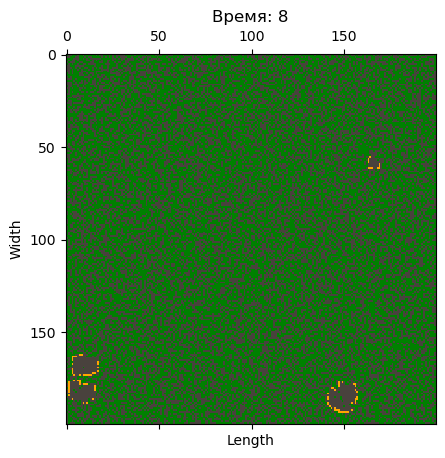

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_15668\3440446224.py", line 1, in <module>
    dynamic_simulation('x')
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_15668\2823324693.py", line 15, in dynamic_simulation
    new_ca = update(ca, n_type)
             ^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_15668\1954471492.py", line 15, in update
    neighbors = get_neuman_neighborhood(cell, ca_shape)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_15668\307580509.py", line -1, in get_neuman_neighborhood
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\interactiv

In [136]:
dynamic_simulation('x')



# TESTS



In [231]:
NeighborhoodType.CROSS.value == '+'

True

In [17]:
CellColor.FIRING.value

'orange'

In [60]:
matrix = np.zeros((2, 3))
type(matrix)
matrix.shape


(2, 3)

In [34]:
cmap_forest.__dict__

{'monochrome': False,
 'colors': ['#49423D', 'orange', 'green'],
 'name': 'from_list',
 'N': 3,
 '_rgba_bad': (0.0, 0.0, 0.0, 0.0),
 '_rgba_under': None,
 '_rgba_over': None,
 '_i_under': 3,
 '_i_over': 4,
 '_i_bad': 5,
 '_isinit': True,
 'colorbar_extend': False,
 '_lut': array([[0.28627451, 0.25882353, 0.23921569, 1.        ],
        [1.        , 0.64705882, 0.        , 1.        ],
        [0.        , 0.50196078, 0.        , 1.        ],
        [0.28627451, 0.25882353, 0.23921569, 1.        ],
        [0.        , 0.50196078, 0.        , 1.        ],
        [0.        , 0.        , 0.        , 0.        ]])}

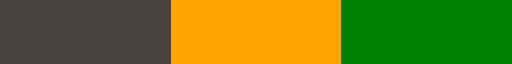

In [35]:
cmap_forest

In [65]:
np.random.random((2, 3)) + 1e-10

array([[0.66740844, 0.8666307 , 0.40132994],
       [0.21191216, 0.2414354 , 0.04951354]])

In [222]:
zeros = create_ca(5, 7)
trees = grow_trees(zeros, 0.5)
print(trees)
print()
firing = firing_trees(trees, 2)
print(firing)

[[0. 0. 0. 2. 2. 0. 0.]
 [2. 2. 2. 0. 2. 0. 2.]
 [0. 0. 0. 0. 0. 2. 0.]
 [2. 2. 0. 0. 2. 0. 0.]
 [2. 2. 2. 0. 0. 0. 2.]]

[[0. 0. 1. 2. 2. 0. 0.]
 [2. 2. 2. 0. 2. 0. 2.]
 [1. 0. 0. 0. 0. 2. 0.]
 [2. 2. 0. 0. 2. 0. 0.]
 [2. 2. 2. 0. 0. 0. 2.]]


In [240]:
cell = (1, 2)
cell_array = np.array([cell for _ in range(4)])
cell_array

array([[1, 2],
       [1, 2],
       [1, 2],
       [1, 2]])

In [272]:
matrix

array([[0., 0., 0.],
       [0., 0., 0.]])

In [75]:
cell = (0, 2)
ca_shape = (5, 7)

print(get_cross_neighborhood(cell, ca_shape))
print(get_neuman_neighborhood(cell, ca_shape))

[[None None]
 [1 2]
 [0 1]
 [0 3]]
[[None None]
 [1 2]
 [0 1]
 [0 3]
 [None None]
 [1 3]
 [1 1]
 [None None]]


In [90]:
np.random.rand()

0.43874186734630505